# Experiment 8

In [1]:
from copy import deepcopy
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, shapiro, ttest_ind

from population.population import Population
from utils.dictionary import *
from utils.myutils import load_dict

In [30]:
# Hyperparameters
use_backup = True
# populations = ['default', 'biased', 'gru_nr']
populations = ['default', 'gru_nr']
# populations = ['default', 'biased']
max_v = 30
max_g = 100
hops = 10

In [31]:
# Parameters
FOLDER = f"population{'_backup' if use_backup else ''}/storage/experiment8/"
COLORS = [sns.color_palette()[i] for i in range(10)]
TITLES = {
    'default': 'NEAT-GRU',
    'biased': 'OPTIMISED',
    'gru_nr': 'NEAT-SRU-U',
}

## Final result

### Fetch

In [32]:
# The dataframe which only concerns the last generation
df_sol = pd.DataFrame()
for p in populations:
    results = []
    for v in range(1, max_v+1):
        temp = load_dict(f'{FOLDER}{p}/v{v}/evaluation/{max_g:05d}/results')
        results.append(max([t['Fitness'] for t in temp.values()]))
    df_sol[p] = results

### Analyse

,default,gru_nr
0,4.433534,3.901886
1,3.941045,4.217767
2,4.273178,3.853896
3,4.202701,3.864039
4,4.690362,3.774737
5,4.128300,3.801315
6,4.045464,4.204621
7,4.197117,4.058280
8,4.566661,4.193806
9,4.823381,3.556775


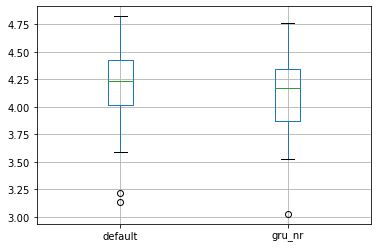

In [33]:
df_sol.boxplot()
df_sol

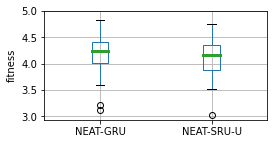

In [40]:
plt.figure(figsize=(4,2))
df_sol.boxplot(medianprops={'linewidth':3})
plt.ylabel('fitness')
plt.yticks([round(3+i/2,1) for i in range(5)])
plt.xticks([i for i in range(1,3)], ['NEAT-GRU', 'NEAT-SRU-U'])
plt.savefig("delete_me/temp_boxplot.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig("delete_me/temp_boxplot.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

###  Statistics

Compare the final results (the fitness at gen100) of the data.

In [6]:
# Do not consider the outliers
Q1 = df_sol.quantile(0.25)
Q3 = df_sol.quantile(0.75)
IQR = Q3 - Q1
df_sol = df_sol[(df_sol >= (Q1 - 1.5 * IQR)) & (df_sol <= (Q3 + 1.5 * IQR))]
IQR

default    0.404229
biased     0.321862
gru_nr     0.474878
dtype: float64

In [7]:
# Example of the Shapiro-Wilk Normality Test
for pop in populations:
    stat, p = shapiro(df_sol[pop].dropna())
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'{pop} is probably Gaussian (p={p:.5f})')
    else:
        print(f'{pop} is probably not Gaussian (p={p:.5f})')

stat=0.974, p=0.687
default is probably Gaussian (p=0.68723)
stat=0.957, p=0.333
biased is probably Gaussian (p=0.33331)
stat=0.979, p=0.801
gru_nr is probably Gaussian (p=0.80098)


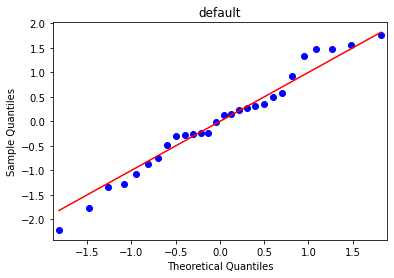

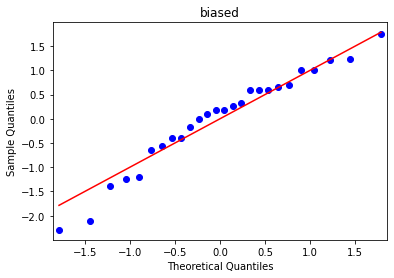

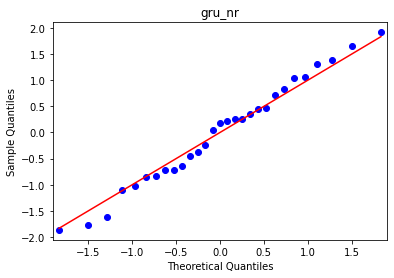

In [8]:
for p in populations:
    sm.qqplot(df_sol[p].dropna(), line ='s', fit=True) 
    plt.title(p)
    plt.show() 

In [9]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = mannwhitneyu(df_sol[pop1].dropna(), 
                               df_sol[pop2].dropna(), 
                               use_continuity=False, 
                               alternative='two-sided')
        print(f'{pop1} vs {pop2} -  p={p} - {"significant" if p < .05 else "insignificant"}')

default vs biased -  p=0.0005709347401077529 - significant
default vs gru_nr -  p=0.1463404546788889 - insignificant
biased vs gru_nr -  p=3.853264199450186e-06 - significant


In [10]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = ttest_ind(df_sol[pop1].dropna(), 
                            df_sol[pop2].dropna())
        print(f'{pop1} vs {pop2} -  p={p} - {"significant" if p < .05 else "insignificant"}')

default vs biased -  p=0.00021197304757273423 - significant
default vs gru_nr -  p=0.10294855347664952 - insignificant
biased vs gru_nr -  p=6.082200825417274e-07 - significant


## Data throughout its lifetime

### Fetch

In [11]:
# 'default' population
data = []
for v in range(1, max_v+1):
    row = []
    for g in range(0,max_g+1,hops):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}default/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FITNESS] for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_default = pd.DataFrame(data).transpose()  # Rows indicate generations
df_default.columns = [v for v in range(1, max_v+1)]
df_default

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.126805,0.101633,0.050000,0.233934,0.327431,0.339325,0.328967,0.024798,0.150672,0.036195,...,0.177431,0.076589,0.274061,0.133763,0.067068,0.193684,0.297609,0.207275,0.081373,0.228359
1,1.989438,2.127396,1.310473,3.125223,0.909649,1.360482,3.211603,1.706146,2.567259,3.638776,...,0.882742,1.706798,2.642011,1.817979,1.874606,1.723449,2.416587,1.618331,2.407336,2.038805
2,2.961487,2.534089,1.976462,3.139509,1.276539,2.572645,3.092016,2.443143,2.989573,4.775277,...,1.842822,3.383173,3.651890,3.066244,3.153999,2.725632,2.967159,2.560004,3.732544,3.841512
3,3.441146,2.424617,2.714817,3.598022,1.665802,3.210748,3.239986,2.795792,3.208624,4.775277,...,2.908500,3.572875,3.868428,3.317505,3.449682,3.147576,3.137299,2.926190,3.895986,4.106410
4,3.990679,2.639615,3.089644,3.635355,1.996252,3.156435,3.361441,3.895206,4.148091,4.763007,...,3.625303,3.815851,3.964599,3.389667,3.609956,3.147576,3.159310,3.206322,4.148242,4.118630
5,4.106995,2.769737,3.263029,4.050302,2.147238,3.667577,3.724040,3.858519,4.606316,4.763007,...,4.172205,4.120605,4.196758,3.791838,3.659898,3.333232,3.185493,3.233318,4.542031,4.253365
6,4.162789,3.082459,3.449377,3.891735,2.306245,3.677926,3.783568,4.227342,4.668751,4.723657,...,4.226038,4.120644,4.188411,3.965832,4.262881,3.330664,3.244084,3.333827,4.625073,4.295890
7,4.278171,3.252926,3.626462,4.180924,3.098313,3.622870,3.987695,4.256615,4.668751,4.711361,...,4.367625,4.201678,4.396356,4.150417,4.339924,3.217996,3.398359,3.613967,4.728925,4.108170
8,4.357510,3.252674,3.683472,4.180924,3.153837,3.736347,4.120402,4.237638,4.682665,4.705055,...,4.453445,4.098451,4.360764,4.129152,4.339924,3.544088,3.549260,4.084654,4.745372,3.962428
9,4.345988,3.623530,4.054629,4.197221,4.606053,4.025181,4.163817,4.220711,4.682122,4.860543,...,4.587743,4.317112,4.370704,4.297323,4.358415,3.754612,3.525316,4.242246,4.716371,4.098954


In [12]:
# 'gru_nr' population
data = []
for v in range(1, max_v+1):
    row = []
    for g in range(0,max_g+1,hops):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}gru_nr/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FITNESS] for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_gru_nr = pd.DataFrame(data).transpose()  # Rows indicate generations
df_gru_nr.columns = [v for v in range(1, max_v+1)]
df_gru_nr

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.156048,0.080691,0.069907,0.138917,0.053134,0.153652,0.178346,0.061173,0.136151,0.217417,...,0.158420,0.187629,0.179461,0.226030,0.024115,0.130385,0.024954,0.024514,0.061239,0.183872
1,2.476002,3.126799,1.069502,1.743819,0.628329,1.027974,2.439807,3.376216,1.766950,2.021245,...,1.803602,3.047463,1.948476,2.364693,2.734676,1.002972,3.138642,1.292238,2.179443,2.577080
2,3.137368,3.676572,3.011294,3.441800,1.310980,1.359591,3.761198,3.853109,3.293189,2.189106,...,2.908970,3.565233,2.915454,2.689415,3.177113,3.368175,3.193004,2.680134,2.353373,3.099926
3,3.150766,3.751116,3.413886,3.635455,1.744564,1.512387,4.192663,4.077763,3.364808,3.240291,...,3.072776,3.746148,4.005686,3.559450,3.391891,3.501265,3.429637,3.046553,3.681894,3.105308
4,3.201373,3.986651,3.578233,3.800397,2.476164,2.281302,4.307949,4.077763,3.381364,3.396658,...,3.330538,4.008615,4.321141,4.222100,3.410010,3.647525,3.520989,2.870671,4.032315,3.222551
5,3.594190,4.135158,3.763934,3.731302,2.658765,2.749509,4.388189,3.911971,3.908636,3.395785,...,3.467426,4.005947,4.314480,4.331093,3.688292,3.757952,3.683453,2.934464,4.246455,3.294395
6,3.310188,4.135716,3.523174,3.747646,2.990278,3.448622,4.382606,3.922173,3.953072,3.379673,...,3.672620,4.096034,4.442276,4.331093,3.759900,3.957532,3.583483,3.159205,4.287527,3.051837
7,3.576015,4.206963,3.733330,3.703552,3.287396,3.783671,4.382606,3.922417,4.003380,3.427020,...,3.954723,4.357104,4.465127,4.354889,3.864615,3.932160,3.944563,3.201077,4.338000,3.318984
8,3.628713,4.213775,3.823057,3.553979,3.676105,3.783671,4.247758,4.004709,4.051243,3.486915,...,4.222928,4.360977,4.360001,4.164980,3.873307,4.151871,3.955310,3.414850,4.308147,3.248747
9,3.668481,4.128112,3.758078,3.648109,3.772470,3.707399,4.238658,4.045259,4.098325,3.596846,...,4.423864,4.338070,4.561890,4.215552,4.024527,4.208542,4.225947,3.741254,4.494074,3.463231


In [13]:
# 'biased' population
data = []
for v in range(1, max_v+1):
    row = []
    for g in range(0,max_g+1,hops):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}biased/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FITNESS] for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_biased = pd.DataFrame(data).transpose()  # Rows indicate generations
df_biased.columns = [v for v in range(1, max_v+1)]
df_biased

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.115264,0.215772,0.050018,0.174669,0.095919,0.135221,0.243556,0.118306,0.124377,0.105093,...,0.042237,0.179380,0.270821,0.217791,0.048462,0.192170,0.245334,0.610784,0.172314,0.024115
1,1.046696,3.676311,2.146224,2.269551,2.113905,2.114707,2.621355,1.729156,3.633864,1.752015,...,1.695648,0.654125,3.500848,2.114138,3.331517,1.240560,3.197277,0.777648,3.793369,2.901407
2,1.777647,3.714755,3.008915,3.477012,2.908226,3.322373,3.058498,2.618778,4.332502,2.431926,...,3.311496,1.921058,4.130446,2.833432,3.866569,3.680862,4.462375,2.071019,3.798973,3.521779
3,2.545361,4.091895,3.361248,3.826317,3.546776,4.064863,4.080600,3.274158,4.596982,2.920237,...,3.396544,3.181549,4.313658,3.727081,4.076207,3.818209,4.765190,2.841428,4.089695,3.779437
4,2.783155,4.088330,3.563896,3.872672,3.851611,4.176898,4.321965,3.885388,4.586705,3.006257,...,3.558225,3.895376,4.041809,3.820661,4.300999,3.743467,4.639857,3.084288,4.167292,3.771030
5,3.202661,4.149387,3.661168,3.895410,3.862550,4.382228,4.488198,4.046991,4.627837,3.427169,...,4.036633,3.901380,4.210385,4.260759,4.511173,3.928054,4.357225,3.346917,4.302208,4.037544
6,3.264155,4.387390,4.030953,4.405818,4.053993,4.452497,4.462647,4.691389,4.684200,3.438703,...,4.221724,3.900008,4.377848,4.298856,4.586302,3.755521,4.839274,4.199553,4.302208,4.294657
7,3.681930,4.490074,4.109378,4.384869,4.182746,4.507601,4.509110,5.063955,4.666387,3.738883,...,4.302450,3.917772,4.377646,4.541406,4.754683,4.100779,4.388978,4.176465,4.409489,4.409690
8,3.636116,4.500831,4.153034,4.600638,4.277730,4.578865,4.544028,5.046209,4.667625,3.884609,...,4.222818,3.933827,4.716496,4.568725,4.881343,4.161530,4.826509,4.354012,4.506054,4.533084
9,3.592435,4.547839,4.441216,4.555059,4.265624,4.624152,4.669095,4.989994,4.678259,4.025693,...,4.264852,4.058572,5.332158,4.556062,4.832375,4.260963,4.826864,4.629492,4.651342,4.479308


### Plot

In [14]:
def plot_performance(plot_default, plot_biased, plot_gru_nr):
    plt.figure(figsize=(6, 3))
    max_fitness = 0


    ### DEFAULT ###
    if plot_default:
        c = 1
        # Get quantiles
        q1 = df_default.quantile(0.25, axis=1).values
        q2 = df_default.quantile(0.50, axis=1).values
        q3 = df_default.quantile(0.75, axis=1).values

        # Plot
        plt.plot([i for i in range(len(q1))], 
                 q1, 
                 color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q3))], 
                 q3, color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q2))], 
                 q2, 
                 color=COLORS[c], 
                 linestyle="-", 
                 linewidth=2, 
                 label=TITLES['default'])
        plt.fill_between([i for i in range(len(q1))],
                         q1, 
                         q3,
                         color=COLORS[c], 
                         alpha=0.1)
        max_fitness = max(q3.max(), max_fitness)


    ### BIASED ###
    if plot_biased:
        c = 0
        # Get quantiles
        q1 = df_biased.quantile(0.25, axis=1).values
        q2 = df_biased.quantile(0.50, axis=1).values
        q3 = df_biased.quantile(0.75, axis=1).values

        # Plot
        plt.plot([i for i in range(len(q1))], 
                 q1, 
                 color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q3))], 
                 q3, color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q2))], 
                 q2, 
                 color=COLORS[c], 
                 linestyle="-", 
                 linewidth=2, 
                 label=TITLES['biased'])
        plt.fill_between([i for i in range(len(q1))],
                         q1, 
                         q3,
                         color=COLORS[c], 
                         alpha=0.1)
        max_fitness = max(q3.max(), max_fitness)


    ### GRU-NR ###
    if plot_gru_nr:
        c = 2
        # Get quantiles
        q1 = df_gru_nr.quantile(0.25, axis=1).values
        q2 = df_gru_nr.quantile(0.50, axis=1).values
        q3 = df_gru_nr.quantile(0.75, axis=1).values

        # Plot
        plt.plot([i for i in range(len(q1))], 
                 q1, 
                 color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q3))], 
                 q3, color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q2))], 
                 q2, 
                 color=COLORS[c], 
                 linestyle="-", 
                 linewidth=2, 
                 label=TITLES['gru_nr'])
        plt.fill_between([i for i in range(len(q1))],
                         q1, 
                         q3,
                         color=COLORS[c], 
                         alpha=0.1)
        max_fitness = max(q3.max(), max_fitness)


    # Show the figure
    leg = plt.legend(loc='upper center',
                     bbox_to_anchor=(0.5, 1.18),
                     fancybox=True,
                     fontsize=10,
                     ncol=len(populations))
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.xlabel("generation")
    plt.xticks([i for i in range(11)], [i*10 for i in range(11)])
    plt.xlim(0,10)
    plt.ylabel('finished ratio')
    plt.yticks([i for i in range(int(max_fitness)+2)])
    plt.ylim(0,int(max_fitness)+1)
    plt.grid()
    plt.tight_layout()
    name = "experiment8"
    if plot_default: name += "_default"
    if plot_biased: name += "_biased"
    if plot_gru_nr: name += "_gru_nr"
    plt.savefig(f"delete_me/{name}.png", bbox_inches='tight', pad_inches=0.02)
    plt.show()
    plt.close()

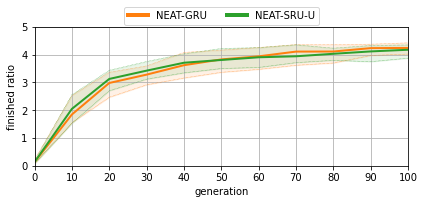

In [15]:
plot_performance(plot_default=True, plot_biased=False, plot_gru_nr=True)

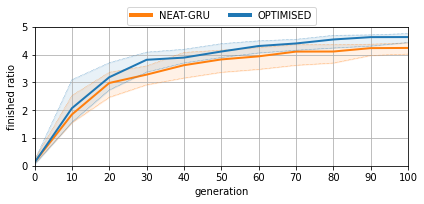

In [16]:
plot_performance(True, True, False)